In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [46]:
from google.colab import files
uploaded = files.upload()


Saving fare_prediction_dataset.csv to fare_prediction_dataset (1).csv


In [ ]:
# Load the dataset
df = pd.read_csv('fare_prediction_dataset.csv')

In [ ]:
# Drop rows with missing key values
df.dropna(subset=['trip_distance_km', 'claimed_mileage_kmpl', 'fuel_price_per_litre'], inplace=True)


In [ ]:
# Replace 0 in mileage with NaN to avoid division by zero
df['claimed_mileage_kmpl'].replace(0, np.nan, inplace=True)
df.dropna(subset=['claimed_mileage_kmpl'], inplace=True)


/tmp/ipython-input-5-1221080721.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['claimed_mileage_kmpl'].replace(0, np.nan, inplace=True)


In [ ]:
# Vehicle age
df['vehicle_age'] = 2025 - df['year_of_manufacture']
df['age_factor'] = df['vehicle_age'].apply(lambda x: max(0.7, 1.0 - 0.05 * x))


In [ ]:
# AC factor
df['AC_factor'] = df['AC_on'].apply(lambda x: 1.05 if x else 1.0)


In [ ]:
# Ride type factor
ride_type_map = {'Shared': 1.0, 'Exclusive': 1.2}
df['ride_type_factor'] = df['ride_type'].map(ride_type_map)


In [ ]:
# Car type factor
car_type_map = {'Hatch': 1.0, 'Sedan': 1.1, 'SUV': 1.2}
df['car_type_factor'] = df['car_type'].map(car_type_map)


In [ ]:
# Time of day factor
def time_factor(t):
    return 1.2 if str(t).lower() in ['morning', 'evening'] else 1.0
df['time_of_day_factor'] = df['time_of_day'].apply(time_factor)


In [ ]:
# Day type factor
df['day_type_factor'] = df['day_type'].apply(lambda x: 1.1 if x == 'Weekend' else 1.0)



In [ ]:
# Area surge
surge_map = {'High': 0.1, 'Medium': 0.0, 'Low': -0.1}
df['area_surge'] = df['area_supply_status'].map(surge_map)


In [ ]:
# M2 calculation
df['M2'] = (df['age_factor'] * df['AC_factor'] * df['ride_type_factor'] *
            df['car_type_factor'] * df['time_of_day_factor'] * df['day_type_factor']) + df['area_surge']


In [ ]:
# Full rule-based fare with minimum base fare (₹40)
df['predicted_fare_rule'] = (
    (df['trip_distance_km'] / df['claimed_mileage_kmpl']) *
    df['fuel_price_per_litre'] * df['M2']
).apply(lambda x: max(x, 40))


In [ ]:
y = df['predicted_fare_rule']  # your formula-based target


In [ ]:
# Drop rows with missing actual fare (target)
df.dropna(subset=['actual_fare_paid'], inplace=True)


In [ ]:
# Final features for ML
features = ['trip_distance_km', 'claimed_mileage_kmpl', 'fuel_price_per_litre',
            'vehicle_age', 'AC_on', 'ride_type_factor', 'car_type_factor',
            'time_of_day_factor', 'day_type_factor', 'area_surge']
X = df[features]
y = df['actual_fare_paid']


In [ ]:
# Drop rows where any feature or target is NaN or Inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=features + ['actual_fare_paid'], inplace=True)


In [ ]:
# Feature and label split
X = df[features]
y = df['actual_fare_paid']


In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))


In [ ]:
# Decision Tree Regression
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))


In [ ]:
# Rule-Based Model RMSE
rule_rmse = np.sqrt(mean_squared_error(df['actual_fare_paid'], df['predicted_fare_rule']))


In [ ]:
# Results
print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Decision Tree RMSE: {rmse_tree:.2f}")
print(f"Rule-Based Fare RMSE: {rule_rmse:.2f}")

Linear Regression RMSE: 33.29
Decision Tree RMSE: 31.94
Rule-Based Fare RMSE: 41.19


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest RMSE: {rmse_rf:.2f}")


Random Forest RMSE: 19.30


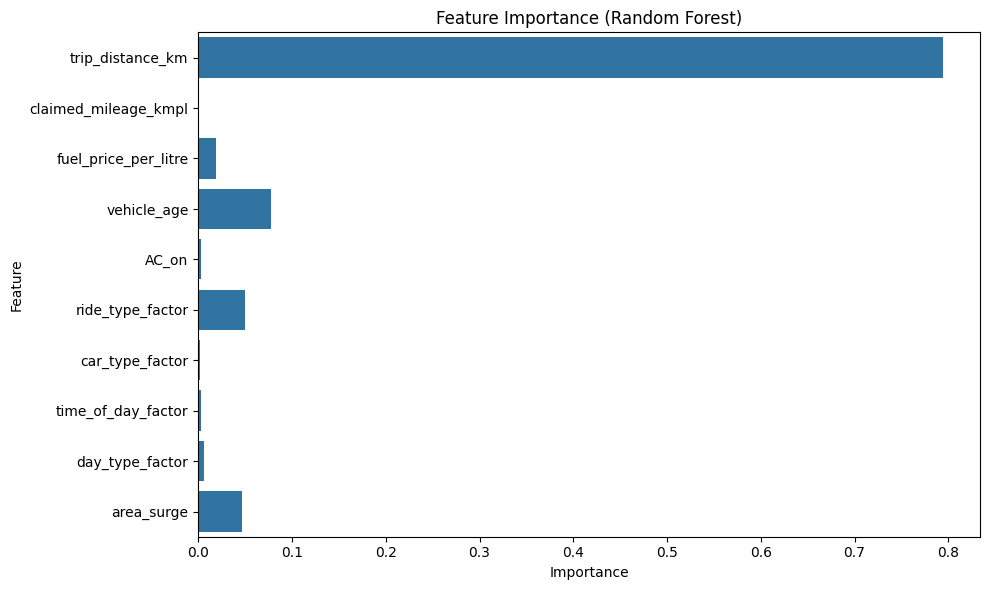

In [ ]:
# Plot Feature Importances
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


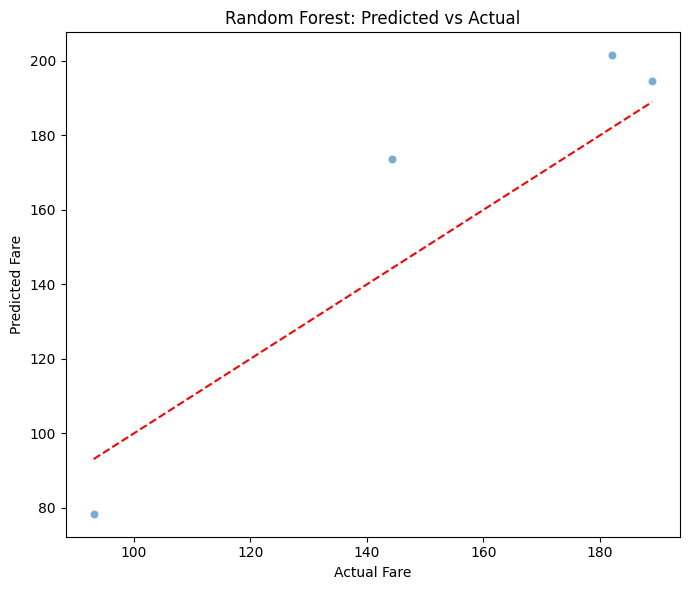

In [ ]:
# Scatter Plot
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # y=x line
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Random Forest: Predicted vs Actual")
plt.tight_layout()
plt.show()


In [ ]:
print("\n📊 Final RMSE Comparison:")
print(f"Linear Regression     : {rmse_lr:.2f}")
print(f"Decision Tree         : {rmse_tree:.2f}")
print(f"Random Forest         : {rmse_rf:.2f}")
print(f"Rule-Based Formula    : {rule_rmse:.2f}")



📊 Final RMSE Comparison:
Linear Regression     : 33.29
Decision Tree         : 31.94
Random Forest         : 19.30
Rule-Based Formula    : 41.19


In [ ]:
import streamlit as st
import joblib
import numpy as np
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(features, "model_features.pkl")

print("Model and features saved successfully.")


Model and features saved successfully.


In [ ]:
# Load model and features
model = joblib.load("random_forest_model.pkl")
features = joblib.load("model_features.pkl")

In [ ]:
st.title("Fare Prediction App 🚕")
st.markdown("Enter trip and car details below to predict the expected fare:")


2025-06-30 13:24:10.471 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 13:24:10.569 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-06-30 13:24:10.570 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 13:24:10.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 13:24:10.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 13:24:10.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-30 13:24:10.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [ ]:
with open("app.py", "w") as f:
    f.write("""import streamlit as st
import numpy as np

st.title("Fare Prediction App 🚕")
st.markdown("Enter trip and car details below to predict the expected fare:")

# User Inputs
trip_distance_km = st.number_input("Trip Distance (km)", min_value=0.1, step=0.1)
claimed_mileage_kmpl = st.number_input("Claimed Mileage (km/l)", min_value=1.0, step=0.5)
fuel_price_per_litre = st.number_input("Fuel Price (Rs/litre)", min_value=50.0, step=1.0)
vehicle_age = st.slider("Vehicle Age (years)", 0, 20, 5)
AC_on = st.selectbox("AC On?", [True, False])

# Dropdowns
ride_type = st.selectbox("Ride Type", ["Shared", "Exclusive"])
car_type = st.selectbox("Car Type", ["Hatch", "Sedan", "SUV"])
time_of_day = st.selectbox("Time of Day", ["Normal", "Rush Hour"])
day_type = st.selectbox("Day Type", ["Weekday", "Weekend"])
area_surge = st.slider("Area Surge (e.g. 0.1 for High Demand, -0.1 for Low)", -0.2, 0.2, 0.0, step=0.05)

# Prediction
if st.button("Predict Fare"):
    # Define multipliers
    age_factor = max(0.7, 1.0 - 0.05 * vehicle_age)
    AC_factor = 1.05 if AC_on else 1.0
    ride_type_factor = 1.0 if ride_type == "Shared" else 1.2
    car_type_factor = {"Hatch": 1.0, "Sedan": 1.1, "SUV": 1.2}[car_type]
    time_of_day_factor = 1.2 if time_of_day == "Rush Hour" else 1.0
    day_type_factor = 1.1 if day_type == "Weekend" else 1.0

    # M2 calculation
    M2_core = age_factor * AC_factor * ride_type_factor * car_type_factor * time_of_day_factor * day_type_factor
    M2 = M2_core + area_surge

    # Fare calculation
    base_fare = (trip_distance_km / claimed_mileage_kmpl) * fuel_price_per_litre * M2
    fare = max(base_fare, 40)

    # Display final fare
    st.success(f"Estimated Fare: Rs {fare:.2f}")

    # Generate receipt
    receipt = f\"""Fare Receipt - Tiaro

Trip Distance     : {trip_distance_km} km
Claimed Mileage   : {claimed_mileage_kmpl} km/l
Fuel Price        : Rs {fuel_price_per_litre}/litre
Vehicle Age       : {vehicle_age} years
AC On             : {'Yes' if AC_on else 'No'}
Ride Type         : {ride_type}
Car Type          : {car_type}
Time of Day       : {time_of_day}
Day Type          : {day_type}
Area Surge        : {area_surge:+.2f}

-------------------------------------
Raw Fare           : Rs {base_fare:.2f}
Final Fare (min Rs 40): Rs {fare:.2f}
-------------------------------------

Thank you for riding with Tiaro!
\"""

    st.download_button("🧾 Download Fare Receipt", receipt, file_name="fare_receipt.txt")
""")


In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2ySJQ3hoL0qzgTf7BACjCuBjHLO_4NroBe6nF6rw3BXYoT81g")


In [ ]:
!streamlit run app.py &>/content/log.txt &


In [ ]:
public_url = ngrok.connect(8501)
print("Your app is live at:", public_url)


Your app is live at: NgrokTunnel: "https://9083-34-16-183-125.ngrok-free.app" -> "http://localhost:8501"


Mileage Prediction

In [47]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

st.title("Fare & Mileage Prediction App 🚕")

trip_distance_km = st.number_input("Trip Distance (km)", min_value=0.1, step=0.1)
fuel_price_per_litre = st.number_input("Fuel Price (Rs/litre)", min_value=50.0, step=1.0)
vehicle_age = st.slider("Vehicle Age (years)", 0, 20, 5)
AC_on = st.selectbox("AC On?", [True, False])
ride_type = st.selectbox("Ride Type", ["Shared", "Exclusive"])
car_type = st.selectbox("Car Type", ["Hatch", "Sedan", "SUV"])
time_of_day = st.selectbox("Time of Day", ["Normal", "Rush Hour"])
area_surge = st.slider("Area Surge", -0.2, 0.2, 0.0, step=0.05)

# Simulate training data
np.random.seed(42)
n = 500
train_df = pd.DataFrame({
    'vehicle_age': np.random.randint(0, 20, n),
    'ac_factor': np.random.choice([1.0, 1.2], n, p=[0.6, 0.4]),
    'ride_type_factor': np.random.choice([1.0, 1.2], n),
    'car_type_factor': np.random.choice([1.0, 1.1, 1.2], n),
    'time_of_day_factor': np.random.choice([1.0, 1.2], n)
})

# Create realistic mileage (12–20 km/l base)
train_df['mileage'] = (
    18
    - 0.5 * train_df['vehicle_age']
    - 2.0 * (train_df['ac_factor'] - 1.0)
    - 1.5 * (train_df['car_type_factor'] - 1.0)
    - 1.0 * (train_df['ride_type_factor'] - 1.0)
    - 0.5 * (train_df['time_of_day_factor'] - 1.0)
    + np.random.normal(0, 0.5, n)
)
train_df['mileage'] = train_df['mileage'].clip(lower=8, upper=22)

# Train the mileage prediction model
model = LinearRegression()
model.fit(train_df[['vehicle_age', 'ac_factor', 'ride_type_factor', 'car_type_factor', 'time_of_day_factor']], train_df['mileage'])

# User inputs to model
ac_factor = 1.2 if AC_on else 1.0
ride_type_factor = 1.0 if ride_type == "Shared" else 1.2
car_type_factor = {"Hatch": 1.0, "Sedan": 1.1, "SUV": 1.2}.get(car_type, 1.0)
time_of_day_factor = 1.2 if time_of_day == "Rush Hour" else 1.0

user_X = pd.DataFrame([{
    'vehicle_age': vehicle_age,
    'ac_factor': ac_factor,
    'ride_type_factor': ride_type_factor,
    'car_type_factor': car_type_factor,
    'time_of_day_factor': time_of_day_factor
}])

if st.button("Predict Fare & Mileage"):
    predicted_mileage = model.predict(user_X)[0]
    predicted_mileage = np.clip(predicted_mileage, 8.0, 22.0)

    # Fare logic
    fuel_used = trip_distance_km / predicted_mileage
    base_fare = fuel_used * fuel_price_per_litre
    final_fare = max(40, base_fare * (1 + area_surge))

    # Show output
    st.success(f"Predicted Mileage: {predicted_mileage:.2f} km/l")
    st.success(f"Estimated Fare: Rs {final_fare:.2f}")

    # Fare receipt
    receipt = f"""
Fare & Mileage Receipt - Tiaro

Trip Distance     : {trip_distance_km} km
Fuel Price        : Rs {fuel_price_per_litre}/litre
Vehicle Age       : {vehicle_age} years
AC On             : {'Yes' if AC_on else 'No'}
Ride Type         : {ride_type}
Car Type          : {car_type}
Time of Day       : {time_of_day}
Area Surge        : {area_surge:+.2f}

Predicted Mileage : {predicted_mileage:.2f} km/l
Raw Fare          : Rs {base_fare:.2f}
Final Fare        : Rs {final_fare:.2f}

Thank you for riding with Tiaro!
"""

    st.download_button("🧾 Download Fare Receipt", receipt, file_name="fare_receipt.txt")


Overwriting app.py


In [48]:
!pip install streamlit pyngrok


In [49]:
from pyngrok import ngrok

# Kill any previous tunnels
ngrok.kill()

In [50]:
# Run streamlit + open tunnel
get_ipython().system_raw('streamlit run app.py &')

In [51]:
public_url = ngrok.connect(8501)
print(f"🚀 Your app is live at: {public_url}")


🚀 Your app is live at: NgrokTunnel: "https://8cd4-34-16-183-125.ngrok-free.app" -> "http://localhost:8501"
